# Twitter Analysis using Web Crawler

### Submission by: Manjiri Acharekar (msa530@nyu.edu)

Please run below command if you need any packages to be installed while running this notebook:
```
import sys
!{sys.executable} -m pip install <package-name>
```


## PART 1: Building a Web Crawler to fetch data from Twitter URL

**Target URL:** "https://www.twitter.com/Nike"

**Fetched Details:**
- Tweet Text
- Tweet Posted Date
- Tweet Posted Time
- Mentions in Tweet
- Hashtags
- Number of Replies, Likes and Retweets

**Process**
1. Crawls data using `Beautiful Soup`.
2. Fetches above-given parameters from `Soup Object` and stores it in a `CSV File`.

**Explanation**
- `Beautiful Soup` helps to fetch the Target URL data using `HTML parser`.
- Since the data is fetched is in `HTML format`, the number of tweets fetched is restricted to `~20` which is the count of tweets that get loaded by default on the browser without reloading at the bottom of the page.
- To fetch more `HTML` data, `Selenium Chrome web driver` is used which helps in fetching more amount of data; hence more tweets. Beautiful Soup can scroll down to the bottom of the page using the driver while we fetch the tweets according to the requirements by setting a limit to store count of tweets.
- Tweets can be fetched using `tweepy`(python library for accessing `Twitter API`) as well, which is a more efficient solution to get real-time data (This has also been implemented by me, but not illustrated here as it was not a requirement). But one will need a Twitter developer account with access and consumer tokens to work with the API.
- Also, while using `tweepy`, if tweets are fetched using the Nike `id`, it will fetch all the tweets including replies of Nikes on other accounts (Tweets and replies Page).
- For this assignment, the requirement was to build a Spider Web Crawler which is a more generic way of fetching data from a website where there is no service available to parse data using API Calls.
- Beautiful Soup helps to stick to one page at a time (i.e our Target URL) with dynamic scrolling ability using `Selenium`
- For 500 tweets of Nike, we can simply set the counter and stop our dynamic `Selenium` scroller. 
- The given URL "https://www.twitter.com/Nike" contained official post by Nike Official Account since 2012.
- The URL changes to something like "https://twitter.com/Nike/status/1037387167331364869" (View Comments) or "https://twitter.com/Nike/with_replies" (Replies), which I have avoided as the question specially mentions the target URL.
- Since 2012, Nike has posted a limited amount of Official Twitter Feeds on its user timeline and therefore, I have considered ~700 tweets to analyze which would be better as a sample for analysis. 

In [2]:
# Import Packages
from selenium import webdriver
from bs4 import BeautifulSoup
import time
import numpy as np
import pandas as pd
import csv
from datetime import datetime

In [3]:
# Target URL
url = "https://www.twitter.com/Nike"

In [4]:
# Using Chrome WebDriver
driver = webdriver.Chrome()
driver.get(url)
driver.maximize_window()

In [5]:
# Beautiful Soup scrolls down to the bottom of the page
lastHeight = driver.execute_script("return document.body.scrollHeight")
while True:
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(2)
    newHeight = driver.execute_script("return document.body.scrollHeight")
    if newHeight == lastHeight:
        break
    lastHeight = newHeight

soupfetch = BeautifulSoup(driver.page_source, "html.parser")

In [6]:
# Open/Create a file to append data
csvFile = open('niketweets.csv', 'w+')
# Use csv Writer
csvWriter = csv.writer(csvFile)

In [7]:
# Initializing Parameters
tweet = []
hashtag = []
mentions = []
reply = []
like = [] 
retweet = []
date = []
time = []

In [8]:
# Fetching Twitter Data
row_count = 0
twitterwebdata = soupfetch.find_all('div', {'class': 'content'})
for twitter_tweet in twitterwebdata:
    # Fetch Tweet Text
    try:
        tweet = twitter_tweet.find('p', {'class': 'TweetTextSize'}).text
        #print(tweet)
    except:
        pass
    
    # Fetch Hashtag
    hashtag = []
    for tag in twitter_tweet.find_all('a', {'class': 'twitter-hashtag'}):
        hashtag.append(tag.text[1:])
    if hashtag == []:
        hashtag = np.NaN
    #print(hashtag)
    
    # Fetch Mentions
    mentions = []
    for a in twitter_tweet.find_all('a', {'class': 'twitter-atreply'}):
        try:
            mentions.append(a['href'][1:])
        except:
            pass
    if mentions == []:
        mentions = np.NaN
    #print(mentions)
    
    # Fetch Number of Replies
    thumbs = twitter_tweet.find_all('span', \
                        {'class': 'ProfileTweet-actionCountForPresentation'})
    try:
        reply = thumbs[0].text
        if reply[-1] == 'K':
            reply = int(float(reply[:-1]) * 1000)
        else:
            reply = int(float(reply.encode))
    except:
        pass
    #print(re)
    
    # Fetch Number of Likes
    try:
        like = thumbs[3].text
        if like[-1] == 'K':
            like = int(float(like[:-1])*1000)
        else:
            like = int(float(like))
    except:
        pass
    #print(like)
    
    # Fetch Number of Retweets
    try:
        retweet = thumbs[2].text
        if retweet[-1] == 'K':
            retweet = int(float(retweet[:-1])*1000)
        else:
            retweet = int(float(retweet))
    except:
        pass
    #print(retweet)
    
    # Fetch Posted Tweet Date
    try:
        date = twitter_tweet.find("a",attrs={"class":"tweet-timestamp js-permalink js-nav js-tooltip"})["title"].split('-')[1]
    except:
        date = None
        pass
    #print(date)
    
    # Fetch Posted Tweet Time
    try:
        time = twitter_tweet.find("a",attrs={"class":"tweet-timestamp js-permalink js-nav js-tooltip"})["title"].split('-')[0]
    except:
        time = None
        pass
    #print(time)
    
    #print(tweet, hashtag, mentions, reply, like, retweet, date, time)
    
    # Data Cleaning - Eliminate tweets with No text
    if all(attributes is not None for attributes in [tweet, date, time]):
        csvWriter.writerow([tweet, hashtag, mentions, reply, like, retweet, date, time])        

## PART 2: Performing Exploratory Analysis on Fetched Twitter Data


**Process**
1. Read the `CSV file` and add `Headers`.

2. `Time Analysis`
  - Yearly Analysis
  - Monthly Analysis
  - Most number of tweets on a single day
  - Hourly Analysis
  - Specific Timeframe tweet
  
3. `Hashtag and Mentions Analysis`
  - Most Frequent Hashtags
  - Most Frequent Mentions by Nike
  

**Explanation**
- Time Analysis: 
Observes tweet frequency across years, months and hours of a day; which particular days had most number of tweets and what specific time of the day Nike tweets more frequently. (Time Sensitive)
- Hashtag and Mentions Analysis: 
Frequent Hashtags and mentions in the tweets through all the years.  


## Read CSV and add Headers

In [9]:
# Loading Comma Seperated Data using read_table pandas function in 'nike_data' dataframe
nike_data = pd.read_table("niketweets.csv", sep=",", header=None)

In [10]:
# Adding Headers to Data
nike_data.columns = ["tweet", "hashtag", "mentions", "reply", "like", "retweet", "date", "time"]
nike_data

,tweet,hashtag,mentions,reply,like,retweet,date,time
0,Don’t ask if your dreams are crazy. Ask if the...,['justdoit'],NaN,16000.0,522000,228000,5 Sep 2018,10:09 AM
1,He’s done it again. \n\nNever stop chasing you...,['justdoit'],NaN,257.0,31000,6000,23 Sep 2018,5:55 PM
2,"Yesterday, 2:01:39 seemed crazy. Today, it’s t...",['justdoit'],NaN,214.0,29000,8900,16 Sep 2018,3:56 AM
3,Don't just be the fastest marathon runner in t...,['justdoit'],['EliudKipchoge'],104.0,6100,2600,15 Sep 2018,8:52 AM
4,"Yeah, that’s more like it. #justdoit",['justdoit'],NaN,1200.0,26000,5300,5 Sep 2018,10:14 AM
5,"If you’re a girl from Compton, don’t just beco...",NaN,NaN,310.0,19000,3600,5 Sep 2018,10:14 AM
6,"If you have only one hand, don’t just watch fo...",NaN,NaN,194.0,11000,2000,5 Sep 2018,10:14 AM
7,When they talk about the greatest team in the ...,NaN,NaN,168.0,11000,2400,5 Sep 2018,10:14 AM
8,"Believe in something, even if it means sacrifi...",NaN,NaN,1200.0,36000,17000,5 Sep 2018,10:14 AM
9,Don’t become the best basketball player on the...,NaN,NaN,84.0,12000,2500,5 Sep 2018,10:14 AM


## Time Analysis
**When was Nike Official most active?**

### Yearly Analysis

In [11]:
# Yearly Analysis
nike_data['date'] = pd.to_datetime(nike_data['date'])
yearly_stats = nike_data['date'].dt.year.value_counts()
yearly_stats

2014    206
2013    162
2012    110
2015     88
2016     74
2017     62
2018     54
Name: date, dtype: int64

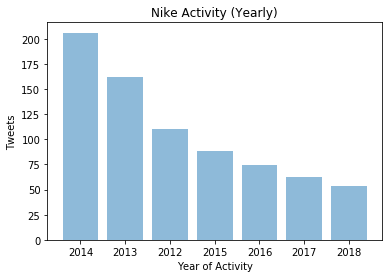

In [12]:
import pandas
from matplotlib import pyplot as plt

tweets = []
year = yearly_stats.keys().tolist()
y_pos = np.arange(len(year))
tweets = yearly_stats.tolist()

plt.bar(y_pos, tweets, align='center', alpha=0.5)
plt.xticks(y_pos, year)
plt.xlabel('Year of Activity')
plt.ylabel('Tweets')
plt.title('Nike Activity (Yearly)')
 
plt.show()

### Observations:
**1) Nike account had most number of tweets in 2014. But from 2015 there is low activity for Nike account.**

**2) One reason can be the different accounts Nike holds like Nike Football, Nike.com, NikeWomen and account for different cities and countries.**

**3) Also Nike has 80 M followers on Instagram as compared to 7.6 M followers on Twitter which means Nike became more active on Instagram as compared to Twitter.**

Link: https://www.businessinsider.com/how-nike-conquered-instagram-2015-12#pretty-much-every-image-is-inspiring-you-to-run-on-the-beach-to-make-a-jump-shot-with-perfect-form-to-dive-off-a-cliff-stein-says-its-making-the-world-your-stadium-3  

Link: https://news.nike.com/news/5-game-changing-nike-innovations-of-2014

### Monthly Analysis

In [13]:
# Monthly Analysis
monthly_stats = nike_data['date'].dt.month.value_counts()
monthly_stats

12    95
10    90
8     74
1     73
3     65
4     58
9     57
5     54
11    52
2     50
7     46
6     42
Name: date, dtype: int64

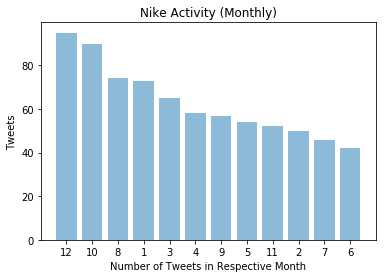

In [14]:
import pandas
from matplotlib import pyplot as plt

tweets = []
month = monthly_stats.keys().tolist()
y_pos = np.arange(len(month))
tweets = monthly_stats.tolist()

plt.bar(y_pos, tweets, align='center', alpha=0.5)
plt.xticks(y_pos, month)
plt.xlabel('Number of Tweets in Respective Month')
plt.ylabel('Tweets')
plt.title('Nike Activity (Monthly)')
 
plt.show()

### Observations:
**1) Festive months of December, October, August, January observe high shopping activities which can be a major reason to market the Nike products.**

**2) Moreover these are the months when Nike releases a lot of new products and therefore the activity is more.**




### Most Number of Tweets on a Single Day

In [15]:
# Most Number of Tweets on a Single Day
day_stats = nike_data['date'].value_counts().head()
day_stats

2017-05-05    19
2018-09-05    13
2012-10-17     8
2014-01-01     8
2012-11-01     8
Name: date, dtype: int64

### Observations:
**1) 5th May 2017 is the day of most number of tweets posted by Nike as it released a number of sneakers and shoes on the first week of May 2017**

Link: http://www.sneakerexclusive.com/may-2017-nike-release-dates/

### Hourly Analysis

In [15]:
# Hourly Analysis
nike_data['time'] = pd.to_datetime(nike_data['time'])
hourly_stats = nike_data['time'].dt.hour.value_counts().head(6)
hourly_stats

9     89
7     83
10    76
11    57
12    57
8     49
Name: time, dtype: int64

### Observations:
**Nike Account is most active between 8 AM to 12 PM (Morning). One business implication can be that the brand is fitness oriented and twitter feeds are designed in such a way that it will inspire a fitness-oriented person to kick off his/her day with some good workout. Also, people tend to surf socially more often in the morning, as their day starts.**

### Specific Timeframe Tweet

In [16]:
# Specific Timeframe Tweet
nike_data['time'] = pd.to_datetime(nike_data['time'])
specific_hourly_stats = nike_data['time'].dt.time.value_counts().head(3)
specific_hourly_stats

07:30:00    43
09:00:00    14
10:14:00    12
Name: time, dtype: int64

### Observations:
**1) 7:30 AM, 9:00 AM and 10:14 AM (Most Tweets)**

**2) Chances that Nike uses automated scheduled tweets to post at a specific time of the day.**





## Hashtag and Mentions Analysis

### Most Frequent Hashtags 
**Which hashtags are used more frequently?**

In [17]:
# Filling Missing Values, Removing Punctation and Brackets from Hashtag Data Frame
nike_data['hashtag'] = nike_data['hashtag'].fillna("None")
nike_data['hashtag'] = nike_data['hashtag'].str.replace(r"\'","")
nike_data['hashtag'] = nike_data['hashtag'].str.replace(r"[","")
nike_data['hashtag'] = nike_data['hashtag'].str.replace(r"]","")
nike_data['hashtag'] = nike_data['hashtag'].str.replace(r",","")
nike_data['hashtag'] = nike_data['hashtag'].str.lower()

In [18]:
# Getting Frequency Count
freq = pd.Series(' '.join(nike_data['hashtag']).split()).value_counts()[1:9]
freq

justdoit          216
makeitcount        28
breaking2          22
airmax             18
nike               12
techpack           11
riskeverything     10
nikewomen           8
dtype: int64

- Above are the Top 8 Hashtags Used by Nike Official.

- These hashtags can be tracked to understand users sentiments with respect to the products. 

### Most Frequent Mentions by Nike
**Nike associates tweets with which twitter account?**

In [19]:
# Filling Missing Values, Removing Punctation and Brackets from Mentions Data Frame
nike_data['mentions'] = nike_data['mentions'].fillna("None")
nike_data['mentions'] = nike_data['mentions'].str.replace(r"\'","")
nike_data['mentions'] = nike_data['mentions'].str.replace(r"[","")
nike_data['mentions'] = nike_data['mentions'].str.replace(r"]","")
nike_data['mentions'] = nike_data['mentions'].str.replace(r",","")

In [20]:
# Getting Frequency Count
new_df = nike_data[nike_data['mentions'].str.contains("Nike") == False]
freq = pd.Series(' '.join(new_df['mentions']).split()).value_counts()[1:6]
freq

serenawilliams    11
EliudKipchoge      8
kobebryant         7
neymarjr           7
KingJames          7
dtype: int64

- Above are the Top 5 Mentions from Nike --> Nike Brand Ambassadors.

- Brand Ambassadors bring in profit significance for Nike.

## PART 3: Advanced Textual Analysis

**`Different Analysis`:**

1. Word Count, Char Count and Average word Count of each tweet.
   
2. Stop Words Count
    
3. Nike Summary Data Stats per tweet
   
4. Lower case, Punctuation removal and Stop words removal
    
5. Most frequent Words in Tweets
    
6. Word Cloud Generation
    
7. Lemmatization

8. Sentiment Analysis

### Word Count, Char Count and Average word Count of each tweet.
- Basic functions while maintaining the properties of each tweet which can be further used by other analysis techniques.

In [21]:
# Keeping Word Count, Char Count and Average Count of Each Tweet
nike_data['word_count'] = nike_data['tweet'].apply(lambda x: len(str(x).split(" ")))

nike_data['char_count'] = nike_data['tweet'].str.len() ## this also includes spaces

def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

nike_data['avg_word'] = nike_data['tweet'].apply(lambda x: avg_word(x))

### Stop Words Count
- Uses Natural Language Toolkit (NLTK) library used to work with human language data building python programs. 
- Stop words are basically most common words used in a language. 

In [22]:
# Counting Stop Words
import nltk
# Try this if it doesn't work --> nltk.download('all')
from nltk.corpus import stopwords
stop = stopwords.words('english')
nike_data['stopwords'] = nike_data['tweet'].apply(lambda x: len([x for x in x.split() if x in stop]))

### Nike Summary Data Stats Per Tweet
- Statistics (mean, min, max) for replies, likes, retweets, word count, char count, average word count and stop words per tweet.

In [23]:
# Nike Summary Data Stats Per Tweet
nike_stats = nike_data.describe().T
del nike_stats['count']
del nike_stats['std']
del nike_stats['25%']
del nike_stats['50%']
del nike_stats['75%']
nike_stats

,mean,min,max
reply,179.165333,1.000000,47000.0
like,5668.841270,1.000000,921000.0
retweet,2911.838624,3.000000,370000.0
word_count,11.309524,1.000000,43.0
char_count,94.912698,6.000000,298.0
avg_word,8.216398,1.333333,48.0
stopwords,3.108466,0.000000,19.0


### Lower case, Punctuation removal and Stop words removal
- Functions like converting data to lower case, removing punctuations and stop words can help to reduce data complexity.

In [24]:
# Converting Data to lower case
nike_data['tweet'] = nike_data['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# Removing Punctuation
nike_data['tweet'] = nike_data['tweet'].str.replace('[^\w\s]','')

# Removing of Stop Words
from nltk.corpus import stopwords
stop = stopwords.words('english')
nike_data['tweet'] = nike_data['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

### Most Frequent Words in Tweets
- Word frequency to understand choice of words. Can help in user profiling.

In [25]:
# Most frequent words in Nike's tweet
freq = pd.Series(' '.join(nike_data['tweet']).split()).value_counts()[:10]
freq

justdoit    122
nike        121
new          49
get          44
one          39
dont         34
make         33
never        27
day          26
game         23
dtype: int64

### Word Cloud Generation
- Word Cloud being a data visualization technique represents text data and helps in analyzing data from various social networking sites. 
- The size of each word in the word cloud indicates its frequency or importance. 
- Textual data points of high significnce can be observed using a word cloud. 
- Uses Wordcloud library and plots using matplotlin.pyplot.

In [26]:
# Word Cloud
# importing all necessery modules 
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
    
comment_words = ' '
stopwords = set(STOPWORDS) 

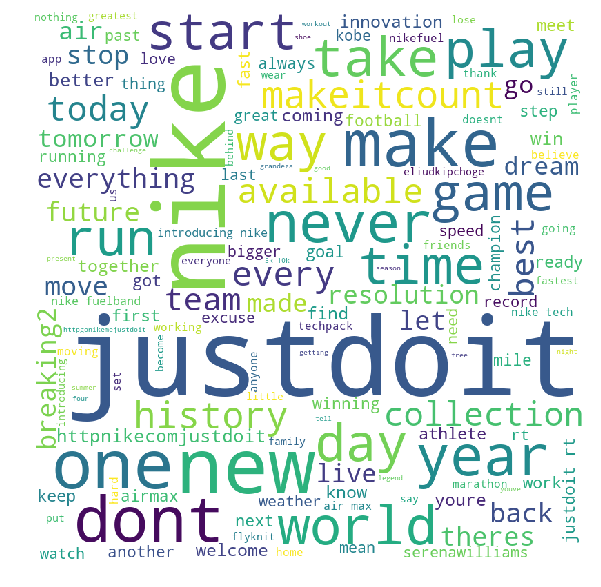

In [27]:
# iterate through the nike tweets 
for val in nike_data['tweet']: 
    # typecaste each val to string 
    val = str(val)
    # split the value 
    tokens = val.split() 
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower()
    for words in tokens: 
        comment_words = comment_words + words + ' '

wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            stopwords = stopwords, 
            min_font_size = 10).generate(comment_words)
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

**The WordCloud clearly indicates that Nike promotes its tagline in most of the tweets and apart from that other significant words are "makeitcount", "run", "game", "world", "collection", "start", "take" and "play". They mainly focus on Nike's product and their marketing.**

### Lemmatization
- Converts the word into its root word instead of just stripping the suffices.
- Effective technique which uses morphological analysis and  vocabulary to obtain root word.
- Helpful in finding N-grams.
- Uses textblob lib.

In [28]:
# Lemmatization
from textblob import TextBlob
TextBlob(nike_data['tweet'][1]).words

from textblob import Word
nike_data['tweet'] = nike_data['tweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

### Sentiment Analysis using Classifier
- To determine if the tweets of the user are positive, negative or neutral.
- `Measure of Polarity`: Negativity or Positivity of a tweet on a -1 to 1 scale.
- `TextBlob` uses a prebuilt dataset which has already labelled positive and negative features for a train text dataset. The data is trained on a Naive Bayes Classification. The classifier can be used to perform Sentimental Analysis on our twitter text data.
- To get the polarity of tweet between -1 to 1 we use `sentiment.polarity` method of `TextBlob`.

In [29]:
# Sentiment Analysis
nike_data['sentiment-polarity'] = nike_data['tweet'].apply(lambda x: TextBlob(x).sentiment.polarity)
nike_data['sentiment-subjectivity'] = nike_data['tweet'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
#nike_data[['tweet','sentiment-polarity','sentiment-subjectivity']]
positive = nike_data[nike_data['sentiment-polarity'] > 0]['tweet'].count()
neutral = nike_data[nike_data['sentiment-polarity'] == 0]['tweet'].count()
negative = nike_data[nike_data['sentiment-polarity'] < 0]['tweet'].count()
total_tweets = nike_data['tweet'].count()

In [30]:
# Nike Tweet Positivity Score
positivity_score = (positive)/total_tweets*100
print('Positivity Score = ', positivity_score)

Positivity Score =  34.2592592593


In [31]:
# Nike Tweet Holistic Positivity Score
holisitic_positivity_score = (positive+neutral)/total_tweets*100
print('Positivity Score (Holistic) = ', holisitic_positivity_score)

Positivity Score (Holistic) =  87.5661375661


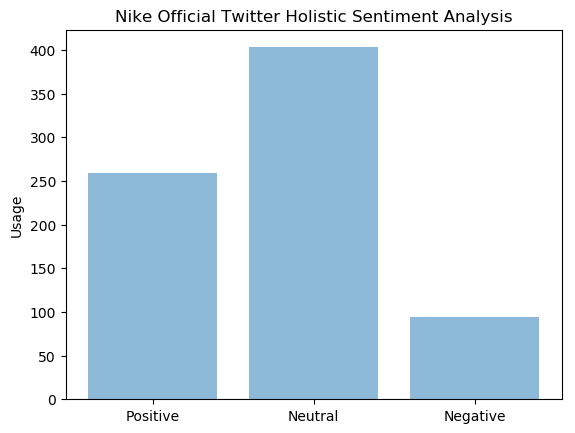

In [32]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = ('Positive', 'Neutral', 'Negative')
y_pos = np.arange(len(objects))
performance = [positive,neutral,negative]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Usage')
plt.title('Nike Official Twitter Holistic Sentiment Analysis')
 
plt.show()

After performing sentimental analysis, looking at the polarity of the data:
- The data has ~88% Holistically Positive Tweets (Considering Neutral). It proves beneficial for Nike on the positive side as the neutral tweets are aligned with positive tweets.
- 12% tweets are classified as negative because the text contains some most common words like "don't", "never" and "no".

#### Subjectivity
- Subjective sentences can be opinions or speculations. 
- There can be few expressions of personal feelings or views. 
- There can be subjective sentences not expressing any sentiment.
- Subjectivity is how objective or subjective the tweet is.
- `Objective - 0` and `Subjective - 1`

In [33]:
# Nike Data Checking if Tweets are Subjective
subjective = nike_data[nike_data['sentiment-subjectivity'] >= 0.40]
sub_positive = subjective[subjective['sentiment-polarity'] > 0]['tweet'].count()
sub_neutral = subjective[subjective['sentiment-polarity'] == 0]['tweet'].count()
sub_negative = subjective[subjective['sentiment-polarity'] < 0]['tweet'].count()
subjective_tweets = subjective['tweet'].count()
subjectivity_score = subjective_tweets/total_tweets*100
print('Subjectivity Score = ', subjectivity_score)
positivity_score = sub_positive/subjective_tweets*100
print('Positivity Score (Subjective Tweets) = ', positivity_score)

Subjectivity Score =  36.2433862434
Positivity Score (Subjective Tweets) =  73.3576642336


- We can see that 36% of the total tweets are subjective.
- Out of which the positive score is 73% which is very high considering that Nike has a good belief in posting feeds which has some positive emotions.
- Overall, Nikes Subjective tweets have positive sentiment.

In [34]:
# Most Liked Tweet (Top 7 out of 10 are Subjective)
nike_liked_stat = nike_data.nlargest(n=10,columns='like')
del nike_liked_stat['sentiment-polarity']
nike_liked_stat

,tweet,hashtag,mentions,reply,like,retweet,date,time,word_count,char_count,avg_word,stopwords,sentiment-subjectivity
16,believe something even mean sacrificing everyt...,justdoit,None,47000.0,921000,370000,2018-09-03,2018-09-27 12:20:00,10,98,8.900000,3,0.687500
0,dont ask dream crazy ask theyre crazy enough j...,justdoit,None,16000.0,522000,228000,2018-09-05,2018-09-27 10:09:00,13,100,6.769231,4,0.766667
18,take superhero costume never take away superpo...,justdoit,None,2500.0,296000,124000,2018-08-24,2018-09-27 21:34:00,18,127,6.111111,9,0.000000
58,another dream come true unbelievable feeling t...,none,None,7000.0,274000,84000,2017-12-07,2018-09-27 13:09:00,23,178,6.782609,7,0.616667
17,crazy dream justdoit serenawilliamspictwitterc...,justdoit,serenawilliams,1300.0,106000,36000,2018-08-27,2018-09-27 08:21:00,11,92,7.454545,5,0.900000
164,alwaysbelievehttpsamptwimgcomv76b1af85b6584b14...,alwaysbelieve,None,532.0,73000,55000,2016-06-19,2018-09-27 19:39:00,1,76,37.500000,0,0.000000
39,tigerwoods play golf world watch welcome backp...,none,TigerWoods,734.0,61000,18000,2018-04-05,2018-09-27 09:43:00,9,87,8.777778,1,0.900000
103,breaking 2hour marathon crazy yes live retweet...,live breaking2,Nike,1000.0,59000,19000,2017-05-04,2018-09-27 20:36:00,17,141,7.235294,4,0.700000
122,long timebut cub make someday todaypictwitterc...,none,Cubs,375.0,54000,29000,2016-11-02,2018-09-27 21:59:00,10,83,7.400000,3,0.400000
199,road closed school cancelled getouthere gear h...,getouthere,None,910.0,54000,41000,2015-10-29,2018-09-27 11:10:00,10,152,10.692308,4,0.100000


In [35]:
# Most Replied Tweet (Top 5 out of 10 are Subjective)
nike_response_stat = nike_data.nlargest(n=10,columns='reply')
del nike_response_stat['sentiment-polarity']
nike_response_stat

,tweet,hashtag,mentions,reply,like,retweet,date,time,word_count,char_count,avg_word,stopwords,sentiment-subjectivity
16,believe something even mean sacrificing everyt...,justdoit,None,47000.0,921000,370000,2018-09-03,2018-09-27 12:20:00,10,98,8.900000,3,0.687500
0,dont ask dream crazy ask theyre crazy enough j...,justdoit,None,16000.0,522000,228000,2018-09-05,2018-09-27 10:09:00,13,100,6.769231,4,0.766667
58,another dream come true unbelievable feeling t...,none,None,7000.0,274000,84000,2017-12-07,2018-09-27 13:09:00,23,178,6.782609,7,0.616667
18,take superhero costume never take away superpo...,justdoit,None,2500.0,296000,124000,2018-08-24,2018-09-27 21:34:00,18,127,6.111111,9,0.000000
233,dont dream justdoithttpgonikeme6018nhyj,justdoit,None,1700.0,26000,25000,2015-04-05,2018-09-27 14:29:00,4,53,12.250000,1,0.000000
17,crazy dream justdoit serenawilliamspictwitterc...,justdoit,serenawilliams,1300.0,106000,36000,2018-08-27,2018-09-27 08:21:00,11,92,7.454545,5,0.900000
549,run jump justdoit 40 vinovine httpsvinecovhiyw...,justdoit vinovine,None,1300.0,4400,6500,2013-08-29,2018-09-27 19:47:00,11,80,6.272727,2,0.000000
4,yeah thats like justdoit,justdoit,None,1200.0,26000,5300,2018-09-05,2018-09-27 10:14:00,6,36,5.166667,1,0.000000
8,believe something even mean sacrificing everyt...,none,None,1200.0,36000,17000,2018-09-05,2018-09-27 10:14:00,9,62,6.000000,3,0.687500
205,realmikefox see tomorrow,none,realmikefox,1100.0,18000,18000,2015-10-20,2018-09-27 18:09:00,4,31,7.000000,1,0.000000


In [36]:
# Most Retweeted Tweet (Top 5 out of 10 are Subjective)
nike_retweet_stat = nike_data.nlargest(n=10,columns='retweet')
del nike_retweet_stat['sentiment-polarity']
nike_retweet_stat

,tweet,hashtag,mentions,reply,like,retweet,date,time,word_count,char_count,avg_word,stopwords,sentiment-subjectivity
16,believe something even mean sacrificing everyt...,justdoit,None,47000.0,921000,370000,2018-09-03,2018-09-27 12:20:00,10,98,8.900000,3,0.687500
0,dont ask dream crazy ask theyre crazy enough j...,justdoit,None,16000.0,522000,228000,2018-09-05,2018-09-27 10:09:00,13,100,6.769231,4,0.766667
18,take superhero costume never take away superpo...,justdoit,None,2500.0,296000,124000,2018-08-24,2018-09-27 21:34:00,18,127,6.111111,9,0.000000
58,another dream come true unbelievable feeling t...,none,None,7000.0,274000,84000,2017-12-07,2018-09-27 13:09:00,23,178,6.782609,7,0.616667
164,alwaysbelievehttpsamptwimgcomv76b1af85b6584b14...,alwaysbelieve,None,532.0,73000,55000,2016-06-19,2018-09-27 19:39:00,1,76,37.500000,0,0.000000
199,road closed school cancelled getouthere gear h...,getouthere,None,910.0,54000,41000,2015-10-29,2018-09-27 11:10:00,10,152,10.692308,4,0.100000
17,crazy dream justdoit serenawilliamspictwitterc...,justdoit,serenawilliams,1300.0,106000,36000,2018-08-27,2018-09-27 08:21:00,11,92,7.454545,5,0.900000
122,long timebut cub make someday todaypictwitterc...,none,Cubs,375.0,54000,29000,2016-11-02,2018-09-27 21:59:00,10,83,7.400000,3,0.400000
204,letter received tinker today thanks nikepictwi...,none,Nike,588.0,38000,29000,2015-10-21,2018-09-27 11:11:00,9,79,7.888889,1,0.200000
202,michael j fox model first selflacing nike magp...,none,Nike,589.0,23000,27000,2015-10-21,2018-09-27 13:27:00,9,79,7.888889,1,0.333333


- The above analysis of checking top liked, replied and retweets show that Nike's concentration has been more on creating content which is subjective.
- As you can see from the above 3 tables, the sentiment of subjectivity is high in most of the tweets leading to positive sentiments.